In [ ]:
!pip install shap

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

from scipy.stats import pointbiserialr, spearmanr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

import shap

# Data load

In [ ]:
### Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### Read in train and test data
train = pd.read_csv(
    filepath_or_buffer='/content/drive/My Drive/airline_satisfaction_project/train.csv',
    index_col=0,
)
test = pd.read_csv(
    filepath_or_buffer='/content/drive/My Drive/airline_satisfaction_project/test.csv',
    index_col=0,
)

# Data prep

## Handling missing values

In [ ]:
# Describe train data
train_summary = train.describe(include='all')
train_summary

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,103904.000000,103904,103904,103904.000000,103904,103904,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000,103904
unique,NaN,2,2,NaN,2,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral or dissatisfied
freq,NaN,52727,84923,NaN,71655,49665,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58879
mean,64924.210502,NaN,NaN,39.379706,NaN,NaN,1189.448375,2.729683,3.060296,2.756901,...,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678,NaN
std,37463.812252,NaN,NaN,15.114964,NaN,NaN,997.147281,1.327829,1.525075,1.398929,...,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682,NaN
min,1.000000,NaN,NaN,7.000000,NaN,NaN,31.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,32533.750000,NaN,NaN,27.000000,NaN,NaN,414.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,NaN
50%,64856.500000,NaN,NaN,40.000000,NaN,NaN,843.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,NaN
75%,97368.250000,NaN,NaN,51.000000,NaN,NaN,1743.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,NaN


In [ ]:
# Describe test data
test_summary = test.describe(include='all')
test_summary

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,25976.000000,25976,25976,25976.000000,25976,25976,25976.000000,25976.000000,25976.000000,25976.000000,...,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000,25976
unique,NaN,2,2,NaN,2,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral or dissatisfied
freq,NaN,13172,21177,NaN,18038,12495,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14573
mean,65005.657992,NaN,NaN,39.620958,NaN,NaN,1193.788459,2.724746,3.046812,2.756775,...,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857,NaN
std,37611.526647,NaN,NaN,15.135685,NaN,NaN,998.683999,1.335384,1.533371,1.412951,...,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539,NaN
min,17.000000,NaN,NaN,7.000000,NaN,NaN,31.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,NaN
25%,32170.500000,NaN,NaN,27.000000,NaN,NaN,414.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000,NaN
50%,65319.500000,NaN,NaN,40.000000,NaN,NaN,849.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000,NaN
75%,97584.250000,NaN,NaN,51.000000,NaN,NaN,1744.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000,NaN


In [ ]:
### Check for missing values
filter = train_summary.loc['count'] != 103904 # Filter
train_summary.loc[:,filter]

,Arrival Delay in Minutes
count,103594.000000
unique,NaN
top,NaN
freq,NaN
mean,15.178678
std,38.698682
min,0.000000
25%,0.000000
50%,0.000000
75%,13.000000


In [ ]:
### Check for missing values
filter = test_summary.loc['count'] != 25976 # Filter
test_summary.loc[:,filter]

,Arrival Delay in Minutes
count,25893.000000
unique,NaN
top,NaN
freq,NaN
mean,14.740857
std,37.517539
min,0.000000
25%,0.000000
50%,0.000000
75%,13.000000


Relatively few missing values so just delete
those rows rather than imputing.

In [ ]:
### Delete rows with missing values
train = train.dropna(subset=['Arrival Delay in Minutes'])
test = test.dropna(subset=['Arrival Delay in Minutes'])

## Encoding

In [ ]:
### List columns for encoding
encoding_columns = list(train_summary.columns[train_summary.loc['unique'].notnull()])
encoding_columns

['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

In [ ]:
### Describe selected columns
train[encoding_columns].describe(include='all')

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,103594,103594,103594,103594,103594
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,52576,84662,71465,49533,58697


All but one categorical column is binary.
The non binary column is ordinal (Class). 
Manually encode columns for easy tracking.\
(Note, the input satisfaction columns are also
ordinal but do not need encoding)

### Encoding function setup

In [ ]:
def binary_encoder(data: pd.DataFrame, column: str, zero_value: str) -> pd.DataFrame:
  '''
  Returns the input dataframe with the target binary column encoded with 0's
  and 1's

    Parameters:
      data (pd.DataFrame): Unencoded dataframe
      column (str): The key of the column to be encoded
      zero_value (str): The column value that will
                be set to zero
      
    Returns:
      encoded_data: The input dataframe with target column encoded
  '''
  data[column] = np.where(data[column]==zero_value, 0, 1)
  return data

In [ ]:
def ordinal_encoder(data: pd.DataFrame, col: str, value_dict: dict) -> pd.DataFrame:
  '''
  Returns dataframe with target column encoded

    Parameters:
      data (pd.DataFrame): Unencoded data
      col (str): Key of column to be encoded
      value_dict (dict): Mapping of unencoded values to encoded values
    
    Returns:
      encoded_data (pd.DataFrame): Input dataframe with target column encoded
  '''
  for column_value in value_dict.keys():
    data[col].mask(data[col]==column_value, value_dict[column_value], inplace=True)
  return data

In [ ]:
### Binary encoding
binary_cols_dict = {} # Store binary cols and zero values
binary_cols_dict['Gender'] = 'Male'
binary_cols_dict['Customer Type'] = 'disloyal Customer'
binary_cols_dict['Type of Travel'] = 'Personal Travel'
binary_cols_dict['satisfaction'] = 'neutral or dissatisfied'
for col in binary_cols_dict.keys():
  train = binary_encoder(data=train,column=col,zero_value=binary_cols_dict[col])
  test = binary_encoder(data=test,column=col,zero_value=binary_cols_dict[col])

### Ordinal encoding
class_dict = {}
class_dict['Eco'] = 0
class_dict['Eco Plus'] = 1
class_dict['Business'] = 2
train = ordinal_encoder(data=train,col='Class',value_dict=class_dict)
test = ordinal_encoder(data=test,col='Class',value_dict=class_dict)

### Check
test.describe(include='all')

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.0,25893.000000,25893.000000,25893.000000,25893.000000,...,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000
unique,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,12457.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,65021.974858,0.506971,0.815317,39.621983,0.694396,NaN,1193.753254,2.723709,3.046422,2.755996,...,3.356969,3.385587,3.349786,3.632681,3.313907,3.648824,3.285521,14.225080,14.740857,0.438922
std,37606.098635,0.499961,0.388048,15.134224,0.460672,NaN,998.626779,1.334711,1.532971,1.412552,...,1.338643,1.282033,1.319045,1.176220,1.269138,1.180650,1.319355,37.185919,37.517539,0.496265
min,17.000000,0.000000,0.000000,7.000000,0.000000,NaN,31.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32209.000000,0.000000,1.000000,27.000000,0.000000,NaN,414.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,65344.000000,1.000000,1.000000,40.000000,1.000000,NaN,849.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,97623.000000,1.000000,1.000000,51.000000,1.000000,NaN,1744.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000


In [ ]:
### Check unique ID's
unique_ids =len(train['id'].unique())
print(f'{train.shape[0]} observations. {unique_ids} unique IDs.')

103594 observations. 103594 unique IDs.


In [ ]:
### Drop ID col (not useful for ML)
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

Each row corresponds to a unique individual.
Data prep is done: no missing values and 
fully encoded.\
Sometimes it is necessary to reduce dimensionality
beyond this point. However, I choose not to for 
two reasons. Firstly, we have sufficient data 
to make up for the number of features. Secondly,
I want to make sure results are interpretable. Data
reduction techniques, e.g. PCA or MDS, make this very
hard. Hence, I will proceed to fit the models whilst
including all the remaining features. 


# Exploratory data analysis

## Checking data imbalances

In [ ]:
train['satisfaction'].value_counts()

0    58697
1    44897
Name: satisfaction, dtype: int64

56% of outcomes are zeros (neutral/dissatisfied).
This isn't a huge imbalance but still noticeable. 
Hence, will use stratified cross validation in ML
section.

## Feature distribution plots

### Function setup

In [ ]:
def kde_plot(feature_data: pd.DataFrame) -> None:
  '''
  Plots KDE plot of features, grouped by labels

    Parameters:
      feature_data (pd.DataFrame): Dataframe with values and labels.
  '''
  sns.kdeplot(x=feature_data.iloc[:,0],hue=feature_data.iloc[:,1],palette='colorblind')

In [ ]:
def count_plot(feature_data: pd.DataFrame) -> None:
  '''
  Plots count plot of features, grouped by labels

    Parameters:
      feature_data (pd.DataFrame): Dataframe with values and labels.
  '''
  sns.countplot(x=feature_data.iloc[:,0],hue=feature_data.iloc[:,1],palette='colorblind')

In [ ]:
def unique_value_counter(data: pd.DataFrame, col: str) -> int:
  '''Count the number of unique values in given column of dataframe

    Parameters:
      data (pd.DataFrame): Dataset containing target column
      col (str): Name of column whose unique values are to be counted
    
    Returns:
      count (int): The number of unique values in target column
  '''
  unique_values = len(data[col].unique())
  return unique_values

In [ ]:
def feature_dist_plot(data: pd.DataFrame, col_feature: str, col_label: str) -> None:
  '''
  Gives appropriate plot of distribution of target column, grouped by label

    Parameters:
      data (pd.DataFrame): Overall dataset
      col_feature (str): Column name of feature column
      col_label: Column name of label column (used for grouping)
  '''
  unique_values = unique_value_counter(data=data,col=col_feature) # Count unique values
  if unique_values < 7: # Decide which plot to produce
    count_plot(data[[col_feature,col_label]])
  else:
    kde_plot(data[[col_feature,col_label]])

### Execution

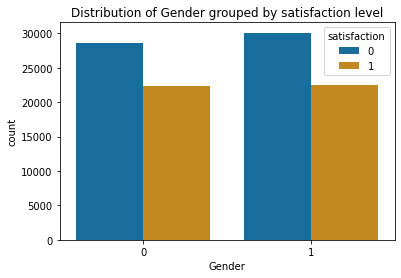

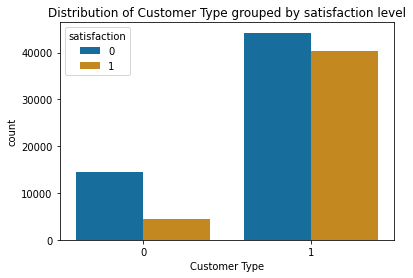

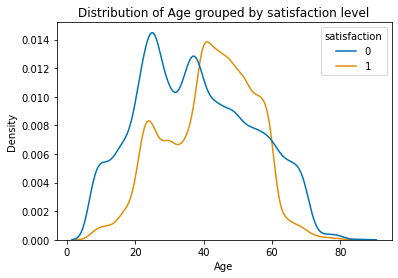

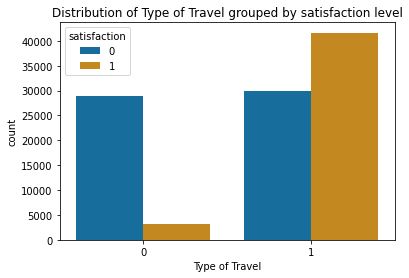

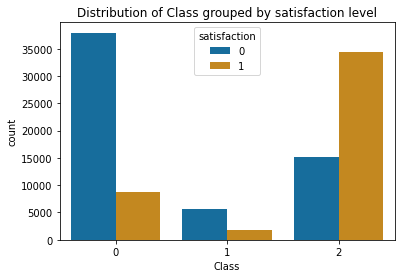

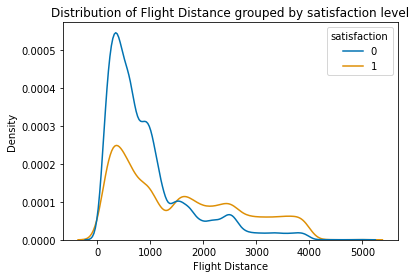

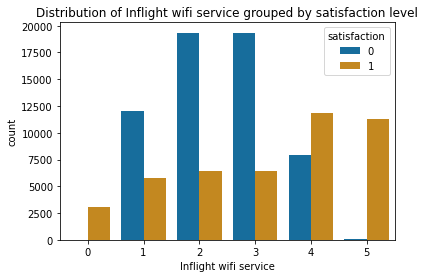

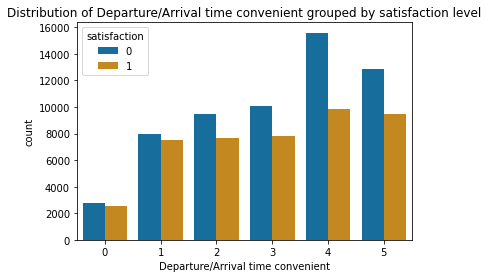

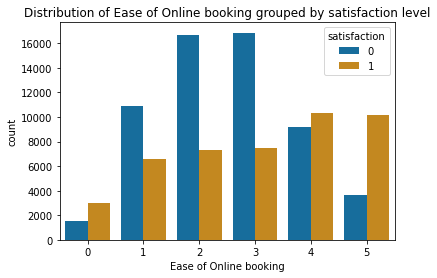

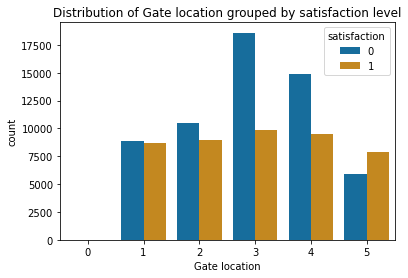

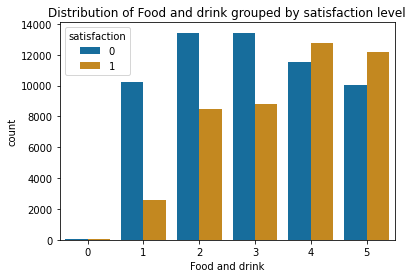

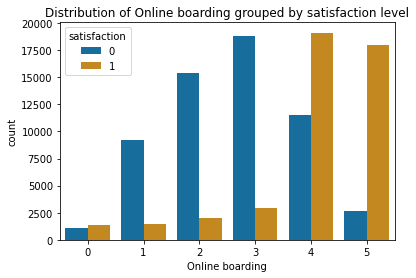

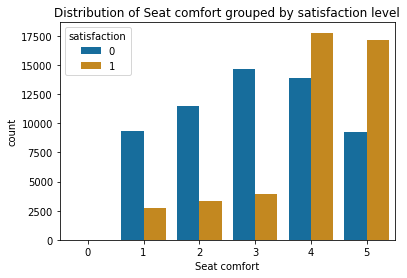

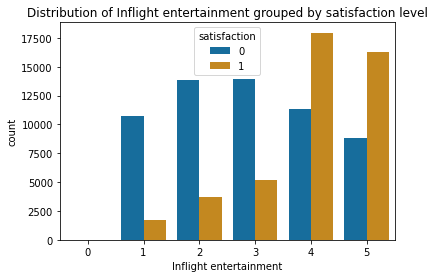

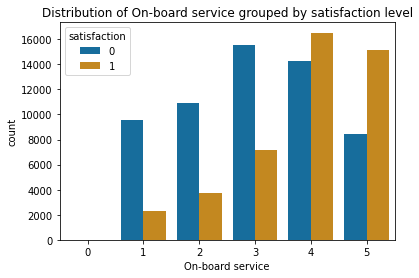

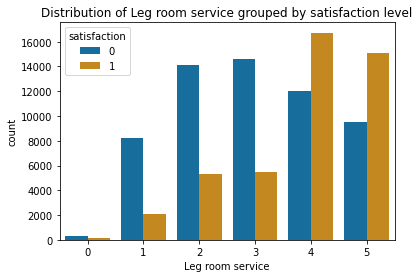

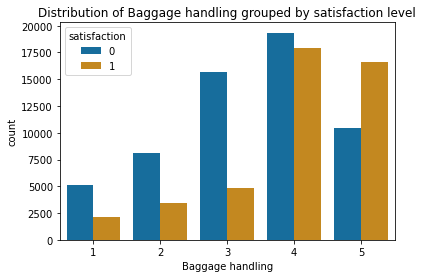

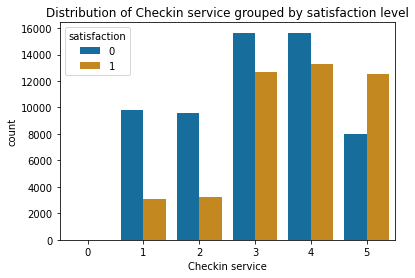

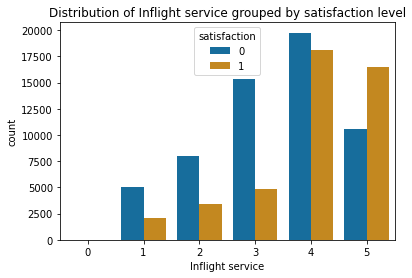

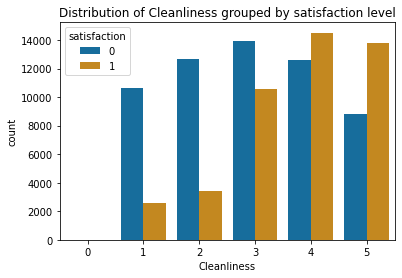

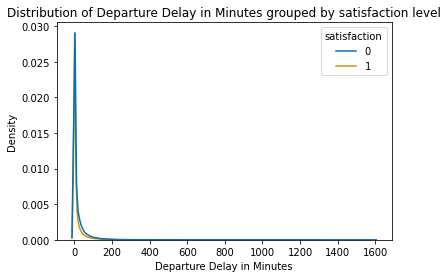

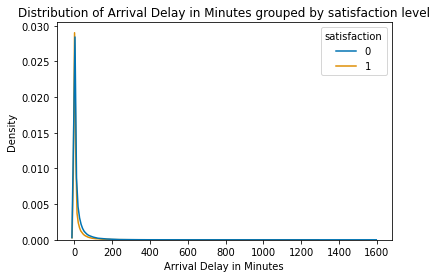

In [ ]:
### Plot the distribution of each feature
feature_columns = list(train.columns) # Store feature columns
feature_columns.remove('satisfaction')

for column in feature_columns:
  feature_dist_plot(data=train,col_feature=column,col_label='satisfaction')
  plt.title(f'Distribution of ' + column + ' grouped by satisfaction level')
  plt.show()

## Feature and target correlations

A simple approach would be to calculate
spearman correlation between each feature 
and target label. However Spearman correlation
is not best for binary outcomes with continuous
features.\
Instead, I will calculate biserial correlation for 
continuous features. For categorical features,
I will use Spearman correlation.

### Function setup

In [ ]:
def biserial_correlation(data: pd.DataFrame, col_feature: str, col_label: str) -> float:
  '''
  Calculate the biserial correlation between feature and label.
  Used when feature is continuous and label is binary.

    Parameters:
      data (pd.DataFrame): Dataset
      col_feature (str): Name of feature column
      col_label (str): Name of label column

    Returns:
      correlation (float): Value of correlation in [-1,1]
  '''
  r = pointbiserialr(x=train[col_label],y=train[col_feature])[0]
  return r

In [ ]:
def spearman_correlation(data: pd.DataFrame, col_feature: str, col_label: str) -> float:
  '''
  Calculate spearman correlation between feature and label.
  Used when feature and label are categorical.

    Parameters:
      data (pd.DataFrame): Dataset
      col_feature (str): Name of feature column
      col_label (str): Name of label column

    Returns:
      correlation (float): Value of similarity in [0,1]
  '''
  r = spearmanr(a=train[col_label],b=train[col_feature])[0]
  return r

In [ ]:
def feature_finder(data: pd.DataFrame, col_target: str) -> list:
  '''
  Return a list of feature names from dataframe

    Parameters:
      data (pd.DataFrame): Dataset with column titles
      col_target (str): Name of target column

    Returns:
      features_list (list): List of feature names
  '''
  feature_names = list(data.columns)
  feature_names.remove(col_target) # Keep all but target column
  return feature_names

In [ ]:
def correlation_dict(data: pd.DataFrame,col_target: str) -> dict:
  '''
  Create a dictionary with feature names as keys and correlation
  of that feature with target as values

    Parameters:
      data (pd.DataFrame): Full dataset

    Returns:
      correlation_dict (dict): Dict: keys are features, values are correlations
  '''
  feature_names = feature_finder(data=data,col_target=col_target) # Store feature names
  corr_dict = {}
  for feature in feature_names:
    if unique_value_counter(data=data,col=feature) < 10: # Decide which r to calculate
      corr_dict[feature] = spearman_correlation(data=data,col_feature=feature,col_label=col_target)
    else:
      corr_dict[feature] = biserial_correlation(data=data,col_feature=feature,col_label=col_target)
  return corr_dict

### Execution

In [ ]:
### Calculate and store the correlations
feature_correlations = correlation_dict(data=train,col_target='satisfaction')
correlations_as_df = pd.DataFrame(data=[(k,v) for k,v in feature_correlations.items()],
                  columns=['Feature','Correlation'])
correlations_as_df
### Make a nice table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Feature', 'Correlation'],
                align='left'),
    cells=dict(values=[correlations_as_df.Feature,correlations_as_df.Correlation],
               align='left'))
])
fig.show()

The table shows how features are correlated with
the target, i.e. satisfaction. It shows that many
features are well correlated (e.g. online boarding
satisfaction, class of flight, type of travel).
This is a good indicator that the features may have
predictive power.\
Some features are not very correlated (e.g.
satisfaction with gate location or gender). To prevent
adding noise to the model, I will drop these two 
features.

In [ ]:
### Drop features with low correlation
train = train.drop(columns=['Gender','Gate location'])
test = test.drop(columns=['Gender','Gate location'])
train.head()

,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Food and drink,Online boarding,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,13,0,1,460,3,4,3,5,3,...,5,4,3,4,4,5,5,25,18.0,0
1,0,25,1,2,235,3,2,3,1,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,26,1,2,1142,2,2,2,5,5,...,5,4,3,4,4,4,5,0,0.0,1
3,1,25,1,2,562,2,5,5,2,2,...,2,2,5,3,1,4,2,11,9.0,0
4,1,61,1,2,214,3,3,3,4,5,...,3,3,4,4,3,3,3,0,0.0,1


There are now 20 features.

# Machine learning models

## Splitting data
Train/ test splits already done. Just seperate
feature and target

In [ ]:
x_train, y_train = train.iloc[:,0:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,0:-1], test.iloc[:,-1]

## Random forest

### Parameter tuning

In [ ]:
### Establish cross validated random forest
rf = RandomForestClassifier(n_estimators=100)
parameter_space = {'max_features':[0.3,0.4,0.5],
           'max_samples':[0.7,0.8,0.9]}
clf = GridSearchCV(estimator=rf,param_grid=parameter_space,scoring='balanced_accuracy',cv=5,n_jobs=-1)

### Fit and report optimised parameters
clf.fit(x_train,y_train)
print(clf.best_params_)

{'max_features': 0.5, 'max_samples': 0.8}


### Testing and evaluation

In [ ]:
### Fit optimised RF on whole training data
rf_optim = RandomForestClassifier(
    n_estimators=100,
    max_features=clf.best_params_['max_features'],
    max_samples=clf.best_params_['max_samples']
)
rf_optim.fit(x_train,y_train)

### Predict
train_predictions_rf = rf_optim.predict(x_train)
test_predictions_rf = rf_optim.predict(x_test)
probas_predicted_rf = rf_optim.predict_proba(x_test)[:,1]

### Report accuracy
print(f'Training accuracy ---> {accuracy_score(y_train,train_predictions_rf)}')
print(f'Test accuracy ---> {accuracy_score(y_test,test_predictions_rf)}')

Training accuracy ---> 0.9996717956638416
Test accuracy ---> 0.9632333062989997


Model accuracy is high. The model does
appear to overfit slightly. The cross validator even
chooses parameter values that would least address
overfitting, of the given options. This suggests that
it may not possible for RF to tackle this overfitting
issue.\
Next, try a linear model to see if this reduces
overfitting.

## Linear Discriminant Analysis

### Parameter tuning

In [ ]:
### Establish cross validated LDA
lda = LinearDiscriminantAnalysis()
parameter_space = {'shrinkage':['auto',None],
           'solver':['eigen','lsqr']}
clf = GridSearchCV(estimator=lda,param_grid=parameter_space,scoring='balanced_accuracy',cv=5,n_jobs=-1)

### Fit and report optimised parameters
clf.fit(x_train,y_train)
print(clf.best_params_)

{'shrinkage': 'auto', 'solver': 'eigen'}


### Testing and evaluation

In [ ]:
### Fit optimised RF on whole training data
lda_optim = LinearDiscriminantAnalysis(
    shrinkage=clf.best_params_['shrinkage'],
    solver=clf.best_params_['solver']
)
lda_optim.fit(x_train,y_train)

### Predict
train_predictions_lda = lda_optim.predict(x_train)
test_predictions_lda = lda_optim.predict(x_test)
probas_predicted_lda = lda_optim.predict_proba(x_test)[:,1]

### Report accuracy
print(f'Training accuracy ---> {accuracy_score(y_train,train_predictions_lda)}')
print(f'Test accuracy ---> {accuracy_score(y_test,test_predictions_lda)}')

Training accuracy ---> 0.8714500839816978
Test accuracy ---> 0.8682269339203645


In thise case, there is far less overfitting (the
model is also way faster to run!!!).\
However, the reduced flexibility has resulted in a 
far lower accuracy. Hence, in thise case, the more 
complex model (Random Forest) is a better chioce.

## Model Comparison

### Performance metrics

In [ ]:
### Calculate performance metrics
# F1 score
f1_score_rf = f1_score(y_test,test_predictions_rf)
f1_score_lda = f1_score(y_test,test_predictions_lda)

# Accuracy score
accuracy_rf = accuracy_score(y_test,test_predictions_rf)
accuracy_lda = accuracy_score(y_test,test_predictions_lda)

# AUC-ROC
auc_roc_rf = roc_auc_score(y_test,probas_predicted_rf)
auc_roc_lda = roc_auc_score(y_test,probas_predicted_lda)

### Make a table
### Make a nice table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Metric','Random Forest', 'LDA'],
                align='left'),
    cells=dict(values=[['F1 Score','Accuracy','AUC-ROC'],
                       [f1_score_rf,accuracy_rf,auc_roc_rf],
                       [f1_score_lda,accuracy_lda,auc_roc_lda]],
               align='left'))
])
fig.show()

As expected, random forest outperforms LDA
across all performance metrics.

# Model interpretation- SHAP values

In [ ]:
### Establish and fit the explainer
explainer = shap.explainers.Tree(rf_optim,x_test.astype('float64'))
shap_values = explainer(x_test)

## Beeswarm plot (global interpretability)

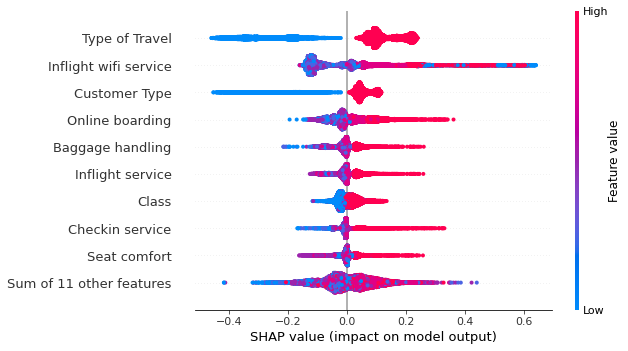

In [ ]:
shap.plots.beeswarm(shap_values[:,:,1])

The beeswarm plot shows how each value of each
variable (or at least the top 9!) affect the 
output of the random forest model, i.e. the 
predicted probability of the customer being satisfied.
The graph shows the top 9 features that drive
customer satisfaction.

## Bar plot (global interpretability)

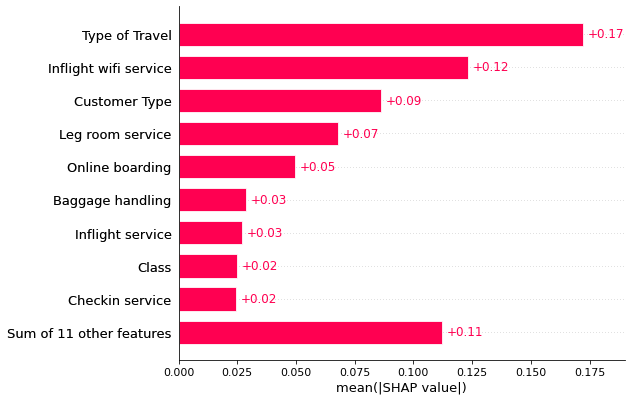

In [ ]:
shap.plots.bar(shap_values[:,:,1])

This barplot gives the average shap value for each
of the features, i.e. how much that feature affects
the prediction on average. It shows that the two 
most important drivers of customer satisfaction, type 
of travel and customer type, are generally more
important than the bottom eleven features combined.

## Waterfall plot (local interpretability)

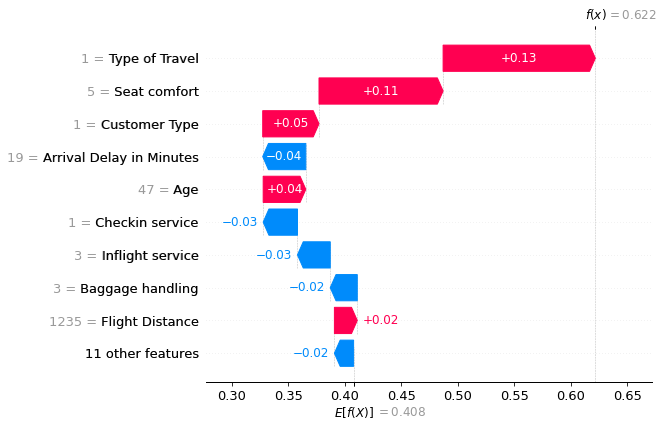

In [ ]:
shap.plots.waterfall(shap_values[10,:,1])

The waterfall plot above gives an example of how 
one specific prediction is explained. It shows that
this observation corresponds to a person who was 
travelling for business, which signifcantly boosts their predicted likelihood of being satisfied. This 
customer also had the highest possible value 
for seat comfort satisfaction. They are also a loyal customer, customer type = 1.\
There were a few factors that negatively affected
their likelihood of being predicted as satisfied. For
example, they had a 19 minute delay and weren't happy
with their checkin service, rating it 1 out of 5.\
However, these affects were not enough to outweigh
the positive drivers. Hence, the predicted probability
of being satisfied was 0.622 and the model correctly
predicted the customer would be satisfied with their
airline experience!